In [1]:
import numpy as np
import pandas as pd
import os
import re
import sys
import time
import unicodedata
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.model_selection import train_test_split


import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed, Bidirectional
from tensorflow.keras.layers import Layer
from tensorflow.keras.callbacks import ModelCheckpoint, Callback
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import to_categorical

## 1. Encoder

Encoder consists of following parts:

1. Embedding

2. Positional Encoding

3. Multi-Head Attention

4. Position-wise Feed-Forward Network

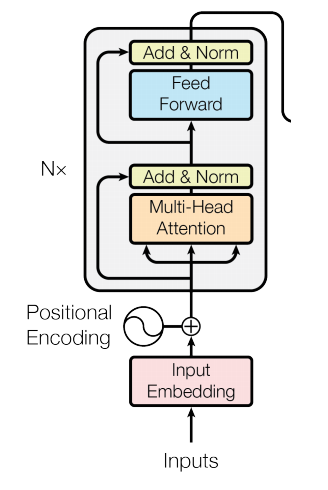

In this notebook we will be implementing two of them:

1. Positional Encoding

2. Multi-Head Attention

### 1.1 Positional Encoding

Transformers don't have sequential nature thus positional info is lost. To incorporate positional info, positional encoding is created for word and added to word embedding.

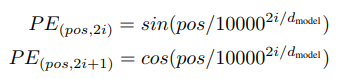

Positional encoding is basically a vector (for a particular word). This vector collectively encoded positional info of word. For each index of this vector a value is generated using `Position of word in sentence (pos)` and `particular cell of vector (i)`.

**Note :** Positional embedding has same shape as shape of word embeddings of that layer are both are to be added.

In [2]:
def positional_embedding(pos, model_size):
    """
    Positional encoding depends only on two things: 1. Position of word in sequence 2. Index of cell 'i' in current position
    vector. Thus for a given 'pos' any given sequence will have same positional vector.
    
    pos: Position index (starting from 0) of current word in sentence.
    model_size: Length of embedding vector.
    
    Returns:
    =======
    A positional embedding vector of shape [1, pos_embedding_len]
    """
    PE = np.zeros([1, model_size])
    # For each index of positional vector compute a value based on whether index is even or odd.
    for i in range(model_size):
        if i % 2 == 0:
            PE[:,i] = np.sin((pos/10000) ** (2*i / model_size))
        else:
            PE[:, i] = np.cos((pos/10000) ** (2*i / model_size))
    return PE
        

### 1.2 Multi-Head Attention

In sequence models to compute each decoder output different attention $\alpha_{i}$ is given to each output word of encoder. However in transformers there is not sequential nature, thus there are 3 types of attention:

1. Source sequence pays attention to itself (Encoder’s self attention)
2. Target sequence pays attention to itself (Decoder’s self attention)
3. Target sequence pays attention to source sequence (same as Seq2Seq)

To handle these attentions three terms are used (query, key, value):

1. Query: the one which pays attention
2. (Key, Value): the one to which attention is drawn. Key and value are exactly the same within this post.

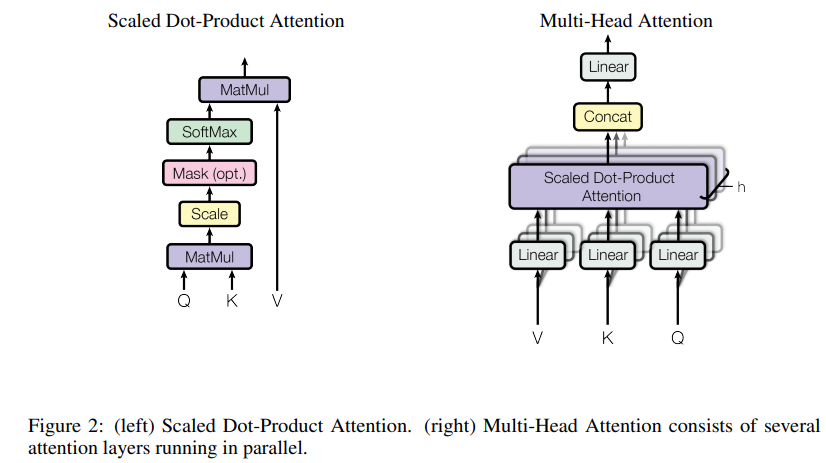

#### 1. Scaled Dot-product attention: 
Figure above shows scaled dot product attention. **Multi-Head Attention** is basically taking multiple copies of scaled dot product attention. Steps are as follows:

$
Attention (Q, K, V) = softmax(Q.K^{T}/\sqrt{model\_size}).V
$

1. $Q$ is a matrix with columns as query vector for each word that is seeking attention.
2. $K$ is a matrix with columns as key vector that is giving attention.
3. Computing multiplication $Q.K^{T}$ computes respective similarity for each word in $K$ i.e. in one step we compute similarity of each **K word** for each **Q word**.
4. Next is scaling step where above product is divided by $\sqrt{model\_size}$
5. Take softmax of scaled dot products to get all $\alpha$'s (i.e. weight of each value word attention for current query word)
6. Multiply softmax with $V$ to get final Attention matrix.

**Note:** If Query is of shape (10,5) i.e. 10 words each of dim-5. Then Attention will also be of same shape (10,5) such that each row of attention is cumulative attention vector for given query word. Now of we add Attention and query then each query word also contains attention vector in itself.

#### 2. Multi-Head Attention : 
In non-multihead attention each of query, key and value vectors for words are of length **model_size**. However in multi-head attention we divide attention computation in h parts. Where each part gets only h-length section of query, key and value. After attention is computed for each of **h** heads, we concatenate them to get overall **model_size** sized attention vector for a word. So overall result is same but results are better.


In [3]:
class MultiHeadAttention(tf.keras.Model):
    def __init__(self, model_size, h):
        super(MultiHeadAttention, self).__init__()
        self.query_size = model_size // h
        self.key_size = model_size // h
        self.value_size = model_size // h
        self.h = h
        # Initialize Wq, Wk, Wv, Wo matrices as layers. Each head has separate matrix.
        self.wq = [tf.keras.layers.Dense(self.query_size) for _ in range(h)]
        self.wk = [tf.keras.layers.Dense(self.key_size) for _ in range(h)]
        self.wv = [tf.keras.layers.Dense(self.value_size) for _ in range(h)]
        # This final layer is used to combine all heads to create one attention of size model_size.
        self.wo = tf.keras.layers.Dense(model_size)
        
    def call(self, query, value):
        return self.multi_head_attention(query, value)
        
    def one_head_attention(self, query, value):
        # query has shape (batch, query_len, model_size)
        # value has shape (batch, value_len, model_size)
        
        # Implement formula for scaled dot product attention explained above.
        score = tf.matmul(query, value, transpose_b=True) / tf.math.sqrt(tf.dtypes.cast(self.key_size, tf.float32))
        # score has shape (batch, query_len, value_len)
        
        alpha = tf.nn.softmax(scores, axis=2) # axis=2 is axis of all value words for given key word.
        # alpha has shape (batch, query_len, value_len)
        
        attention = tf.matmul(alpha, value)
        # attention has shape (batch, query_len, value_size)
        
        return attention
    
    def multi_head_attention(self, query, value):
        # query has shape (batch, query_len, model_size)
        # value has shape (batch, value_len, model_size)
        heads = []
        for i in range(self.h):
            score = tf.matmul(self.wq[i](query), self.wk[i](value), transpose_b=True)
            # Scale score.
            score /= tf.math.sqrt(tf.dtypes.cast(self.key_size, tf.float32))
            # score has shape (batch, query_len, value_len)
            
            alpha = tf.nn.softmax(score, axis=2)
            # alpha has shape (batch, query_len, value_len)
            
            head = tf.matmul(alpha, self.wv[i](value))
            # head has shape (batch, decoder_len, value_size)
            heads.append(head)
            
        # Concatenate all heads and pass them through self.wo to convert to final attention of size model_size.
        # Direct concatenation is also possible but passing through self.wo will lead to learning of combination.
        heads = tf.concat(heads, axis=2)
        attention = self.wo(heads)
        # attention has shape (batch, query_len, model_size)
        return attention
        
        

### 1.3 Create Encoder Model

Encoder has following layers:

1. One embedding layer.
2. One or more group layers, where each group contains following in that order:    
  1. One Multi-Head Attention block
  2. One Normalization layer for Attention block
  3. One Feed-Forward Network block
  4. One Normalization layer for FFN block
  
Encoder follows following pipeline.

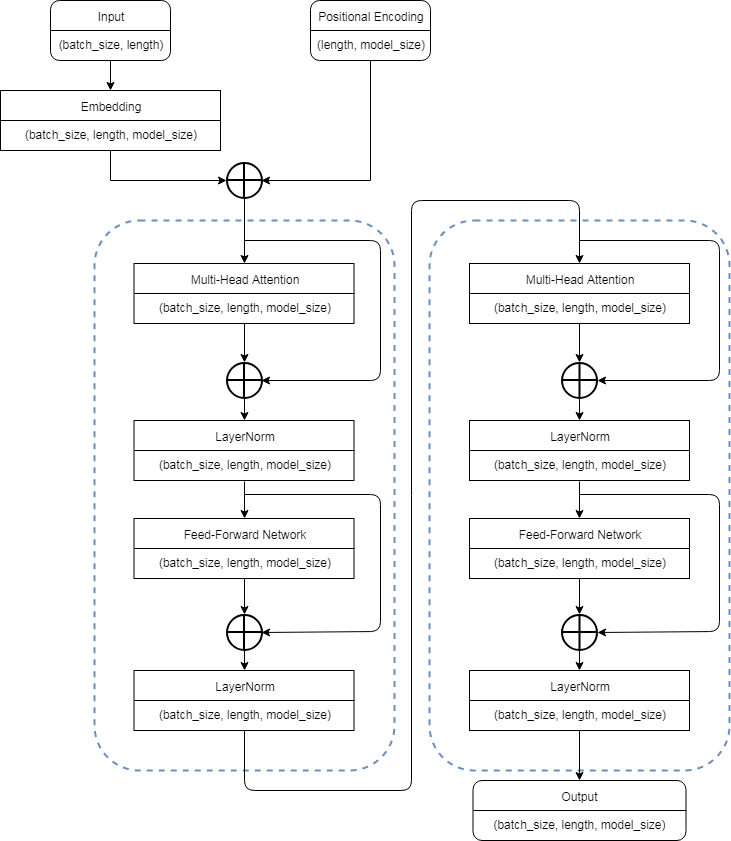

In [4]:
# NON-VECTORIZED.

class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, model_size, num_layers, h):
        """
        vocab_size: size of encoder vocab.
        model_size: Dimensionality of output vectors of embedding layer.
        num_layers: number of grouped layers to be used in encoder.
        h: number of multi-heads.
        """
        super(Encoder, self).__init__()
        self.model_size = model_size
        self.num_layers = num_layers
        self.h = h
        
        #### Define layers.
        # Embedding layer.
        self.embedding = tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=model_size)
        
        # num_layers Multi-Head Attention layers with normalization layer.
        self.attention = [MultiHeadAttention(model_size, h) for _ in range(num_layers)]
        self.attention_norm = [tf.keras.layers.BatchNormalization() for _ in range(num_layers)]
        
        # num_layers Dense layers with normalization. Could also use multiple dense layers in each group.
        self.dense_1 = [tf.keras.layers.Dense(model_size * 4, activation='relu') for _ in range(num_layers)]
        self.dense_2 = [tf.keras.layers.Dense(model_size) for _ in range(num_layers)]
        self.ffn_norm = [tf.keras.layers.BatchNormalization() for _ in range(num_layers)]
        
    def call(self, sequence):
        """
        sequence: shape is (batch_size, seq length encoder) where each value of single sequence is int indicies of words to be
        given to embedding layer.
        """ 
        ########## 1. Embedding + Positional Encoding.
        sub_in = []
        # Iterate for each word.
        for i in range(sequence.shape[1]):
            # Compute embedding at position i for each sequence in batch.
            batch_i = sequence[:,i]
            # batch_i will bat a vector so add extra dimension for axis=1.
            batch_i = tf.expand_dims(batch_i, axis=1)
            embed = self.embedding(batch_i)            
            # Add positional encoding to embedding vectors.
            sub_in.append(embed + pes[i,:])            
        # Concatenate embeddings along dimension=1 i.e. sequence length to get shape (batch_size, sequnce length, model_size)
        sub_in = tf.concat(sub_in, axis=1)
        
        ######### 2. Attention + Residual + Normalization + Fully Connected + Residual + Normalization
        # Iterate over each attention layer and for each word at each position in sub_in[:,j,:] compute its multi-head
        # context using all words of sub_in (i.e. encoder self attention).
        for i in range(self.num_layers):
            ######### 2.1 Attention + Residual + Normalization
            # Compute self-attention for layer i.
            query_wise_attention = []
            for j in range(sub_in.shape[1]):
                # Self-attention of word j with all words in sub_in
                attention = self.attention[i](tf.expand_dims(sub_in[:,j,:], axis=1), sub_in)
                query_wise_attention.append(attention)
            # Concatenate query_wise_attention on dim=1 i.e. seq len to get attention vector for each word in sub_in.
            query_wise_attention = tf.concat(query_wise_attention, axis=1)
            
            # Combine word vector with attention context vector. Also called RESIDUAL CONNECTION.
            query_wise_attention = sub_in + query_wise_attention
            
            # Normalize output of current layer.
            query_wise_attention = self.attention_norm[i](query_wise_attention)
            
            ######### 2.2 Fully Connected + Residual + Normalization
            ffn_in = query_wise_attention
            ffn_out = self.dense_2[i](self.dense_1[i](ffn_in))
            # Residuals.
            ffn_out = ffn_out + ffn_in
            # Normalize.
            ffn_out = self.ffn_norm[i](ffn_out)
            
            # Assign this output ffn_out as input sub_in to next layer.
            sub_in = ffn_out
        # Return output of final group layer of encoder as final encoder output 
        # with shape(batch_size, seq length enc, model_size)
        return ffn_out
            
            

In [5]:
# VECTORIZED. Loops = num_layers.

class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, model_size, num_layers, h):
        """
        vocab_size: size of encoder vocab.
        model_size: Dimensionality of output vectors of embedding layer.
        num_layers: number of grouped layers to be used in encoder.
        h: number of multi-heads.
        """
        super(Encoder, self).__init__()
        self.model_size = model_size
        self.num_layers = num_layers
        self.h = h
        
        #### Define layers.
        # Embedding layer.
        self.embedding = tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=model_size)
        
        # num_layers Multi-Head Attention layers with normalization layer.
        self.attention = [MultiHeadAttention(model_size, h) for _ in range(num_layers)]
        self.attention_norm = [tf.keras.layers.BatchNormalization() for _ in range(num_layers)]
        
        # num_layers Dense layers with normalization. Could also use multiple dense layers in each group.
        self.dense_1 = [tf.keras.layers.Dense(model_size * 4, activation='relu') for _ in range(num_layers)]
        self.dense_2 = [tf.keras.layers.Dense(model_size) for _ in range(num_layers)]
        self.ffn_norm = [tf.keras.layers.BatchNormalization() for _ in range(num_layers)]
        
    def call(self, sequence):
        """
        sequence: shape is (batch_size, seq length encoder) where each value of single sequence is int indicies of words to be
        given to embedding layer.
        """ 
        ########## 1. Embedding + Positional Encoding.
        embed = self.embedding(sequence)
        sub_in = embed + pes[:sequence.shape[1], :]
        
        ######### 2. Attention + Residual + Normalization + Fully Connected + Residual + Normalization
        # Iterate over each attention layer and for each word at each position in sub_in[:,j,:] compute its multi-head
        # context using all words of sub_in (i.e. encoder self attention).
        for i in range(self.num_layers):
            ######### 2.1 Attention + Residual + Normalization
            # Compute self-attention for layer i.
            query_wise_attention = self.attention[i](sub_in, sub_in)
            
            # Combine word vector with attention context vector. Also called RESIDUAL CONNECTION.
            query_wise_attention = sub_in + query_wise_attention
            
            # Normalize output of current layer.
            query_wise_attention = self.attention_norm[i](query_wise_attention)
            
            ######### 2.2 Fully Connected + Residual + Normalization
            ffn_in = query_wise_attention
            ffn_out = self.dense_2[i](self.dense_1[i](ffn_in))
            # Residuals.
            ffn_out = ffn_out + ffn_in
            # Normalize.
            ffn_out = self.ffn_norm[i](ffn_out)
            
            # Assign this output ffn_out as input sub_in to next layer.
            sub_in = ffn_out
        # Return output of final group layer of encoder as final encoder output 
        # with shape(batch_size, seq length enc, model_size)
        return ffn_out

## 2. Decoder

Decoder uses among all layers created for encoder so no new layer is needed. However decoder has few differences as compared to encoder:

1. **Masked Multi-Head Attention:** Implements Decoder self attention. It is same as encoder self attention however it uses mask.
2. **Encoder-Decoder Multi-Head Attention:** Here for each word of decoder, output of encoder provides attention.

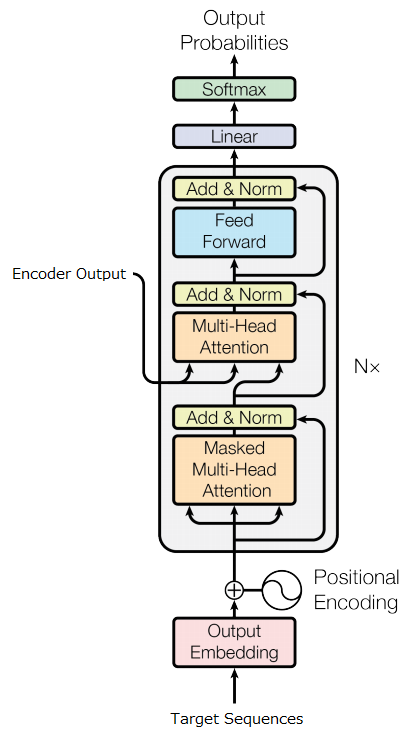

Data pipeline for decoder is as follows:

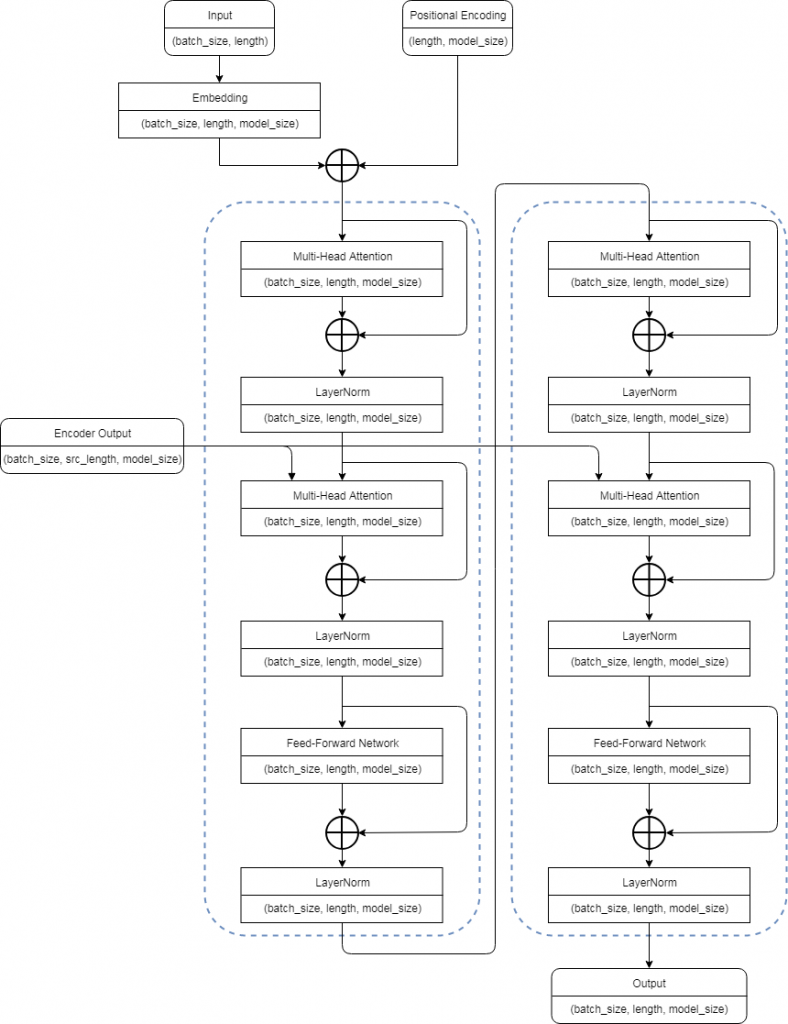


#### Masking in Decoder Self Attention:
In feed forward step of decoder, when we compute self attention we need to mask the input to right. As during prediction time right side token will not be available while predicting current token. Thus masking is used. **To perform masking is simple. Just use tokens upto current token for Key and Value while computing attention for current Query token.**

In [6]:
# NON-VECTORIZED.

class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, model_size, num_layers, h):
        super(Decoder, self).__init__()
        self.model_size = model_size
        self.num_layers = num_layers
        self.h = h
        
        #### Define layers.
        # Embedding layer.
        self.embedding = tf.keras.layers.Embedding(vocab_size, model_size)
        
        # Define number of attention and norm layers.
        self.attention_self = [MultiHeadAttention(model_size, h) for _ in range(num_layers)]
        self.attention_self_norm = [tf.keras.layers.BatchNormalization() for _ in range(num_layers)]
        
        self.attention_enc_dec = [MultiHeadAttention(model_size, h) for _ in range(num_layers)]
        self.attention_enc_dec_norm = [tf.keras.layers.BatchNormalization() for _ in range(num_layers)]
        
        # Define number of dense layers.
        self.dense_1 = [tf.keras.layers.Dense(model_size*4, activation="relu") for _ in range(num_layers)]
        self.dense_2 = [tf.keras.layers.Dense(model_size) for _ in range(num_layers)]
        self.ffn_norm = [tf.keras.layers.BatchNormalization() for _ in range(num_layers)]
        
        # Add single output layer that will predict word probabilities.
        # Here 'softmax' should be used but we will be working with logits so linear activation is used.
        self.dense = tf.keras.layers.Dense(vocab_size)
        
    def call(self, sequence, encoder_output):
        """
        sequences: shape(batch_size, seq len decoder)
        encoder_output: shape(batch_size, seq len encoder, model_size)
        """
        ####### 1. Embedding + Positional Encoding.
        sub_in = []
        for i in range(sequence.shape[1]):
            embed = self.embedding(tf.expand_dims(sequence[:,i], axis=1))
            # Add positional encoding.
            sub_in.append(embed + pes[i,:])
        # Concatenate all embeddings to shape(batch_size, seq len decoder, model_size)
        sub_in = tf.concat(sub_in, axis=1)
        
        # Now loop for self.num_layer times and feed forward through each group layer.
        #################################################################################################
        # NOTE IN CASE OF DECODER SELF ATTENTION, WE WILL NOT CONSIDER WORDS TO THE RIGHT OF CURRENT WORD
        # AS DURING PREDICTION RIGHT WORDS ARE NOT AVAILABLE. DUE TO THIS MASKING IS USED.
        #################################################################################################
        for i in range(self.num_layers):
            ######## 2. Self-Attention + Residual + Norm.
            query_wise_attention = []
            # For each index of batch compute its self attention on all other elements of sub_in.
            # ONE THING TO KEEP IN MIND IS THAT WE NEED TO MASK ALL TOKENS TO RIGHT OF CURRENT TOKEN.
            # TO DO THIS IS SIMPLE ONLY TAKE TOKENS UPTO CURRENT TOKEN FOR KEY AND VALUE.
            for j in range(sub_in.shape[1]):
                value = sub_in[:, :j, :] # Values only upto current index.
                cur_attention = self.attention_self[i](tf.expand_dims(sub_in[:,j,:], axis=1), value)
                query_wise_attention.append(cur_attention)
            # Concatenate all query wise attentions on dim=1 i.e. seq length dimension.
            query_wise_attention = tf.concat(query_wise_attention, axis=1)
            # Residual.
            query_wise_attention = query_wise_attention + sub_in
            # Norm.
            query_wise_attention = self.attention_self_norm[i](query_wise_attention)            
            
            ####### 3. Encoder-Decoder-Attention + Residual + Norm.
            # Here masking is not needed as all values of encoder will always be available.
            # Attention is computed for query=query_wise_attention and value=encoder_output
            enc_dec_att_in = query_wise_attention
            enc_dec_att = []
            for j in range(enc_dec_att_in.shape[1]):
                att = self.attention_enc_dec[i](tf.expand_dims(enc_dec_att_in[:,j,:], axis=1), encoder_output)
                enc_dec_att.append(att)
            # Concatenate along dim=1 i.e. seq lenght dim.
            enc_dec_att = tf.concat(enc_dec_att, axis=1)
            # Residual.
            enc_dec_att = enc_dec_att + enc_dec_att_in
            # Norm.
            enc_dec_att = self.attention_enc_dec_norm[i](enc_dec_att)
            
            ######## 4. Fully Connected + Residual + Norm.
            ffn_in = enc_dec_att
            ffn_out = self.dense_2[i](self.dense_1[i](ffn_in))
            # Residual.
            ffn_out = ffn_out + ffn_in
            # Norm.
            ffn_out = self.ffn_norm[i](ffn_out)
            
            ######## 5. Final logits.
            logits = self.dense(ffn_out)
            # shape(batch_size, seq length decoder, vocab_size decoder)
            return logits
            
            
            

In [7]:
# VECTORIZED.

class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, model_size, num_layers, h):
        super(Decoder, self).__init__()
        self.model_size = model_size
        self.num_layers = num_layers
        self.h = h
        
        #### Define layers.
        # Embedding layer.
        self.embedding = tf.keras.layers.Embedding(vocab_size, model_size)
        
        # Define number of attention and norm layers.
        self.attention_self = [MultiHeadAttention(model_size, h) for _ in range(num_layers)]
        self.attention_self_norm = [tf.keras.layers.BatchNormalization() for _ in range(num_layers)]
        
        self.attention_enc_dec = [MultiHeadAttention(model_size, h) for _ in range(num_layers)]
        self.attention_enc_dec_norm = [tf.keras.layers.BatchNormalization() for _ in range(num_layers)]
        
        # Define number of dense layers.
        self.dense_1 = [tf.keras.layers.Dense(model_size*4, activation="relu") for _ in range(num_layers)]
        self.dense_2 = [tf.keras.layers.Dense(model_size) for _ in range(num_layers)]
        self.ffn_norm = [tf.keras.layers.BatchNormalization() for _ in range(num_layers)]
        
        # Add single output layer that will predict word probabilities.
        # Here 'softmax' should be used but we will be working with logits so linear activation is used.
        self.dense = tf.keras.layers.Dense(vocab_size)
        
    def call(self, sequence, encoder_output):
        """
        sequences: shape(batch_size, seq len decoder)
        encoder_output: shape(batch_size, seq len encoder, model_size)
        """
        ####### 1. Embedding + Positional Encoding.
        embed = self.embedding(sequence)
        sub_in = embed + pes[:sequence.shape[1], :]
                
        # Now loop for self.num_layer times and feed forward through each group layer.
        #################################################################################################
        # NOTE IN CASE OF DECODER SELF ATTENTION, WE WILL NOT CONSIDER WORDS TO THE RIGHT OF CURRENT WORD
        # AS DURING PREDICTION RIGHT WORDS ARE NOT AVAILABLE. DUE TO THIS MASKING IS USED.
        #################################################################################################
        for i in range(self.num_layers):
            ######## 2. Self-Attention + Residual + Norm.
            query_wise_attention = []
            # For each index of batch compute its self attention on all other elements of sub_in.
            # ONE THING TO KEEP IN MIND IS THAT WE NEED TO MASK ALL TOKENS TO RIGHT OF CURRENT TOKEN.
            # TO DO THIS IS SIMPLE ONLY TAKE TOKENS UPTO CURRENT TOKEN FOR KEY AND VALUE.
            for j in range(sub_in.shape[1]):
                value = sub_in[:, :j, :] # Values only upto current index.
                cur_attention = self.attention_self[i](tf.expand_dims(sub_in[:,j,:], axis=1), value)
                query_wise_attention.append(cur_attention)
            # Concatenate all query wise attentions on dim=1 i.e. seq length dimension.
            query_wise_attention = tf.concat(query_wise_attention, axis=1)
            # Residual.
            query_wise_attention = query_wise_attention + sub_in
            # Norm.
            query_wise_attention = self.attention_self_norm[i](query_wise_attention)            
            
            ####### 3. Encoder-Decoder-Attention + Residual + Norm.
            # Here masking is not needed as all values of encoder will always be available.
            # Attention is computed for query=query_wise_attention and value=encoder_output
            enc_dec_att_in = query_wise_attention
            enc_dec_att = self.attention_enc_dec[i](enc_dec_att_in, encoder_output)            
            # Residual.
            enc_dec_att = enc_dec_att + enc_dec_att_in
            # Norm.
            enc_dec_att = self.attention_enc_dec_norm[i](enc_dec_att)
            
            ######## 4. Fully Connected + Residual + Norm.
            ffn_in = enc_dec_att
            ffn_out = self.dense_2[i](self.dense_1[i](ffn_in))
            # Residual.
            ffn_out = ffn_out + ffn_in
            # Norm.
            ffn_out = self.ffn_norm[i](ffn_out)
            
            # Re-initialize sub_in for next layer.
            sub_in = ffn_out
            ######## 5. Final logits.
            logits = self.dense(ffn_out)
            # shape(batch_size, seq length decoder, vocab_size decoder)
            return logits
            
            
            

## 3. Code testing

In [8]:
# Initialization Training.

# Maximum of input and output sequence length.
MAX_SEQ_LEN = 200

# Dimensionality of output vectors of embedding layer.
MODEL_SIZE = 128
VOCAB_SIZE=1000
H = 2
NUM_LAYERS = 2
BATCH_SIZE = 8
NUM_EPOCHS = 50

In [9]:
# Positional encodings are same for each index for any given sequence as face value of position is same. So compute
# these values once.

pes = []
for i in range(MAX_SEQ_LEN):
    pes.append(positional_embedding(i, MODEL_SIZE))
pes = np.concatenate(pes, axis=0)
pes = tf.constant(pes, dtype=tf.float32) # shape is (MAX_SEQ_LEN, MODEL_SIZE)

In [10]:
en_vocab_size = 1000
encoder = Encoder(en_vocab_size, MODEL_SIZE, NUM_LAYERS, H)
en_sequence_in = tf.constant([[1, 2, 3, 4, 6, 7, 8, 0, 0, 0], 
                           [1, 2, 3, 4, 6, 7, 8, 0, 0, 0]])
encoder_output = encoder(en_sequence_in)
print('Input vocabulary size', en_vocab_size)
print('Encoder input shape', en_sequence_in.shape)
print('Encoder output shape', encoder_output.shape)

fr_vocab_size = 500
decoder = Decoder(fr_vocab_size, MODEL_SIZE, NUM_LAYERS, H)
fr_sequence_in = tf.constant([[1, 2, 3, 4, 5, 6, 7, 0, 0, 0, 0, 0, 0, 0,0],
                           [1, 2, 3, 4, 5, 6, 7, 0, 0, 0, 0, 0, 0, 0,0]])
decoder_output = decoder(fr_sequence_in, encoder_output)

print('Target vocabulary size', fr_vocab_size)
print('Decoder input shape', fr_sequence_in.shape)
print('Decoder output shape', decoder_output.shape)

Input vocabulary size 1000
Encoder input shape (2, 10)
Encoder output shape (2, 10, 128)
Target vocabulary size 500
Decoder input shape (2, 15)
Decoder output shape (2, 15, 500)


## 4. Data Preperation

In [11]:
def unicode_to_ascii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', str(s))
        if unicodedata.category(c) != 'Mn')


def normalize_string(s):
    s = unicode_to_ascii(s)
    s = re.sub(r'([!.?])', r' \1', s)
    s = re.sub(r'[^a-zA-Z.!?]+', r' ', s)
    s = re.sub(r'\s+', r' ', s)
    return s


In [12]:
data_home = r"../input/amazon-fine-food-reviews"

In [13]:
df = pd.read_csv(data_home+r"/Reviews.csv")

In [14]:
df

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...
...,...,...,...,...,...,...,...,...,...,...
568449,568450,B001EO7N10,A28KG5XORO54AY,Lettie D. Carter,0,0,5,1299628800,Will not do without,Great for sesame chicken..this is a good if no...
568450,568451,B003S1WTCU,A3I8AFVPEE8KI5,R. Sawyer,0,0,2,1331251200,disappointed,I'm disappointed with the flavor. The chocolat...
568451,568452,B004I613EE,A121AA1GQV751Z,"pksd ""pk_007""",2,2,5,1329782400,Perfect for our maltipoo,"These stars are small, so you can give 10-15 o..."
568452,568453,B004I613EE,A3IBEVCTXKNOH,"Kathy A. Welch ""katwel""",1,1,5,1331596800,Favorite Training and reward treat,These are the BEST treats for training and rew...


In [15]:
# Initialization Training.

# Maximum of input and output sequence length.
MAX_SEQ_LEN_EN = 200
MAX_SEQ_LEN_DE = 20

VOCAB_SIZE_EN=2000
VOCAB_SIZE_DE=2000

# Dimensionality of output vectors of embedding layer.
MODEL_SIZE = 128

LR = 0.0001
H = 2
NUM_LAYERS = 2
BATCH_SIZE = 8
NUM_EPOCHS = 100

# Amount of data to take.
DATA_SIZE = 50000

In [16]:
# Positional encodings are same for each index for any given sequence as face value of position is same. So compute
# these values once.

pes = []
for i in range(max(MAX_SEQ_LEN_EN, MAX_SEQ_LEN_DE)):
    pes.append(positional_embedding(i, MODEL_SIZE))
pes = np.concatenate(pes, axis=0)
pes = tf.constant(pes, dtype=tf.float32) # shape is (MAX_SEQ_LEN, MODEL_SIZE)

In [17]:
encoder = Encoder(VOCAB_SIZE_EN, MODEL_SIZE, NUM_LAYERS, H)
decoder = Decoder(VOCAB_SIZE_DE, MODEL_SIZE, NUM_LAYERS, H)

In [18]:
# Create data.

# Shuffle dataframe.
df = df.sample(frac=1).reset_index(drop=True)

text = df["Text"].tolist()
text = text[:DATA_SIZE]
text = [normalize_string(data) for data in text]

summary = df["Summary"].tolist()
summary = summary[:DATA_SIZE]
summary_in = ['<start> ' + normalize_string(data) for data in summary]
summary_out = [normalize_string(data) + ' <end>' for data in summary]

In [19]:
# Create tokenizers.

text_tokenizer = tf.keras.preprocessing.text.Tokenizer(filters="", num_words=VOCAB_SIZE_EN)
text_tokenizer.fit_on_texts(text)
data_text = text_tokenizer.texts_to_sequences(text)
data_text = tf.keras.preprocessing.sequence.pad_sequences(data_text, padding="post", maxlen=MAX_SEQ_LEN_EN)

summary_tokenizer = tf.keras.preprocessing.text.Tokenizer(filters="", num_words=VOCAB_SIZE_DE)
summary_tokenizer.fit_on_texts(summary_in)
summary_tokenizer.fit_on_texts(summary_out)
data_summary_in = summary_tokenizer.texts_to_sequences(summary_in)
data_summary_in = tf.keras.preprocessing.sequence.pad_sequences(data_summary_in, padding="post", maxlen=MAX_SEQ_LEN_DE)

data_summary_out = summary_tokenizer.texts_to_sequences(summary_out)
data_summary_out = tf.keras.preprocessing.sequence.pad_sequences(data_summary_out, padding="post", maxlen=MAX_SEQ_LEN_DE)

In [20]:
# Loss and optimizer.

crossentropy = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
def loss_func(targets, logits):
    mask = tf.math.logical_not(tf.math.equal(targets, 0))
    mask = tf.cast(mask, dtype=tf.int64)
    loss = crossentropy(targets, logits, sample_weight=mask)
    return loss

optimizer = tf.keras.optimizers.Adam(learning_rate=LR)

In [21]:
@tf.function
def train_step(source_seq, target_seq_in, target_seq_out):
    with tf.GradientTape() as tape:
        encoder_output = encoder(source_seq)
        decoder_output = decoder(target_seq_in, encoder_output)
        loss = loss_func(target_seq_out, decoder_output)
    variables = encoder.trainable_variables + decoder.trainable_variables
    gradients = tape.gradient(loss, variables)
    optimizer.apply_gradients(zip(gradients, variables))
    return loss


def predict(test_source_text=None):
    # If test sentence is not provided
    # randomly pick up one from the training data
    if test_source_text is None:
        test_source_text = text[np.random.choice(len(text))]

    print("Actual Text:",test_source_text)
    
    # Tokenize the test sentence to obtain source sequence
    test_source_seq = text_tokenizer.texts_to_sequences([test_source_text])
    test_source_seq = tf.keras.preprocessing.sequence.pad_sequences(test_source_seq, padding="post", maxlen=MAX_SEQ_LEN_EN)
    #print("Tokenized Actual Text:",test_source_seq)

    en_output = encoder(tf.constant(test_source_seq))

    de_input = tf.constant([[summary_tokenizer.word_index['<start>']]], dtype=tf.int64)

    out_words = []

    while True:
        de_output = decoder(de_input, en_output)
        
        # Take the last token as the predicted token
        new_word = tf.expand_dims(tf.argmax(de_output, -1)[:, -1], axis=1)
        out_words.append(summary_tokenizer.index_word[new_word.numpy()[0][0]])

        # The next input is a new sequence
        # contains both the input sequence and the predicted token
        de_input = tf.concat((de_input, new_word), axis=-1)

        # End if hitting <end> or length exceeds 14
        if out_words[-1] == '<end>' or len(out_words) >= MAX_SEQ_LEN_DE:
            break
    print("Predicted Text:", ' '.join(out_words))

In [22]:
# Training Data.
dataset = tf.data.Dataset.from_tensor_slices(
    (data_text, data_summary_in, data_summary_out))
dataset = dataset.shuffle(20).batch(BATCH_SIZE)

In [23]:
# Train.

if 1==2:
    start_time = time.time()
    for e in range(NUM_EPOCHS):
        for batch, (source_seq, target_seq_in, target_seq_out) in enumerate(dataset.take(-1)):
            #print(batch)
            loss = train_step(source_seq, target_seq_in,
                              target_seq_out)
            sys.stdout.flush()
            sys.stdout.write("\r{} Epoch:{}/{} Loss:{}".format(batch+1, e+1, NUM_EPOCHS,loss))

        end_time = time.time()
        print('\r{:.2f}s Epoch {} Loss {:.4f}'.format((end_time - start_time),
              e + 1, loss.numpy()))
        start_time = end_time

        if e % 2 == 0:
            end_time = time.time()
            print('Average elapsed time: {:.2f}s'.format((end_time - start_time) / (e + 1)))
            try:
                predict()
            except Exception as e:
                print(e)
                continue

In [24]:

for i in range(10):
    print("\n")
    predict()



Actual Text: My cats really love this . I have cats and they all munch down . I have been buying it at Walmart but they seem to be changing their product line and sometimes I can t get it .
Predicted Text: though though though though though though though though though though though though though though though though though though though though


Actual Text: Ordered these because I wanted to try them and none of the stores in my area seem to carry them . Normally I eat the habanero bbq or the wasabi . br br For spiciness they are better than the habanero but not as much as the wasabi can be though in all fairness the wasabi is in a whole different taste spectrum anyway br br Flavorwise is where they lose out . They taste MUCH saltier and the flavor itself is overpowered by that until you get to the end zing where the spice kicks in . br br In summary they are edible and I will finish off the cans that I ordered but I will go back to purchasing my wasabi and habanero after that .
Pred

## 5. Code Optimization

1. **Handle padding using mask:** To make sentences of same length, padding was used. However padding is all zeros and has no meaning. However model could start learning paddings. To remove this situation masking is used. Masking is applied at following places:
  1. **class MultiHeadAttention:** In Multi-Head Attention we want activations at masked positions to be zero after softmax(). To achieve this mark zero positions with large negative values, which after softmax() will be converted to zero (or very less value.)
  2. **Encoder (Encoder-Encoder Attention):** Simply pass mask to encoder and encoder will send it to multihead attention. For this **padding_mask** is used.
  3. **Decoder (Decoder-Encoder Attention):** This will be same as Encoder-Encoder attention and thus same mask **padding_mask** will be used.
  4. **Decoder (Decoder-Decoder Attention):** This case is different. When Decoder uses attention on previous layer outputs of Decoder then it is not allowed to see any word on right of current word. To handle this a different type of mark is used. Such that mask is lower triangular matrix with lower_triangle=1 and upper_triangle=0. This band matrix is created separately for each Grouped Decoder layer.
2. Modify **train_step()** function to generate padding mask for encoder.
3. During prediction **padding_mask** is not passed and thus Multi-Head Attention will skip the step of applying attention. This is intended behaviour as well, as masking is not used during prediction.

In [25]:
class MultiHeadAttention(tf.keras.Model):
    def __init__(self, model_size, h):
        super(MultiHeadAttention, self).__init__()
        self.query_size = model_size // h
        self.key_size = model_size // h
        self.value_size = model_size // h
        self.h = h
        # Initialize Wq, Wk, Wv, Wo matrices as layers. Each head has separate matrix.
        self.wq = [tf.keras.layers.Dense(self.query_size) for _ in range(h)]
        self.wk = [tf.keras.layers.Dense(self.key_size) for _ in range(h)]
        self.wv = [tf.keras.layers.Dense(self.value_size) for _ in range(h)]
        # This final layer is used to combine all heads to create one attention of size model_size.
        self.wo = tf.keras.layers.Dense(model_size)
        
    def call(self, query, value, mask=None):
        return self.multi_head_attention(query, value, mask)
        
    def one_head_attention(self, query, value):
        # query has shape (batch, query_len, model_size)
        # value has shape (batch, value_len, model_size)
        
        # Implement formula for scaled dot product attention explained above.
        score = tf.matmul(query, value, transpose_b=True) / tf.math.sqrt(tf.dtypes.cast(self.key_size, tf.float32))
        # score has shape (batch, query_len, value_len)
        
        alpha = tf.nn.softmax(scores, axis=2) # axis=2 is axis of all value words for given key word.
        # alpha has shape (batch, query_len, value_len)
        
        attention = tf.matmul(alpha, value)
        # attention has shape (batch, query_len, value_size)
        
        return attention
    
    def multi_head_attention(self, query, value, mask):
        # query has shape (batch, query_len, model_size)
        # value has shape (batch, value_len, model_size)
        heads = []
        for i in range(self.h):
            score = tf.matmul(self.wq[i](query), self.wk[i](value), transpose_b=True)
            # Scale score.
            score /= tf.math.sqrt(tf.dtypes.cast(self.key_size, tf.float32))
            # score has shape (batch, query_len, value_len)
            
            if mask is not None:
                # mask must be broadcastable to (batch, query_len, value_len)
                score  = score * mask
                # Now assign masked positions of score to large -ve value -1e9 such that after softmax these values will be 0.
                score = tf.where(tf.equal(score, 0), tf.ones_like(score) * -1e9, score)
            
            alpha = tf.nn.softmax(score, axis=2)
            # alpha has shape (batch, query_len, value_len)
            
            head = tf.matmul(alpha, self.wv[i](value))
            # head has shape (batch, decoder_len, value_size)
            heads.append(head)
            
        # Concatenate all heads and pass them through self.wo to convert to final attention of size model_size.
        # Direct concatenation is also possible but passing through self.wo will lead to learning of combination.
        heads = tf.concat(heads, axis=2)
        attention = self.wo(heads)
        # attention has shape (batch, query_len, model_size)
        return attention
        
        

In [26]:
# VECTORIZED. Loops = num_layers.

class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, model_size, num_layers, h):
        """
        vocab_size: size of encoder vocab.
        model_size: Dimensionality of output vectors of embedding layer.
        num_layers: number of grouped layers to be used in encoder.
        h: number of multi-heads.
        """
        super(Encoder, self).__init__()
        self.model_size = model_size
        self.num_layers = num_layers
        self.h = h
        
        #### Define layers.
        # Embedding layer.
        self.embedding = tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=model_size)
        
        # num_layers Multi-Head Attention layers with normalization layer.
        self.attention = [MultiHeadAttention(model_size, h) for _ in range(num_layers)]
        self.attention_norm = [tf.keras.layers.BatchNormalization() for _ in range(num_layers)]
        
        # num_layers Dense layers with normalization. Could also use multiple dense layers in each group.
        self.dense_1 = [tf.keras.layers.Dense(model_size * 4, activation='relu') for _ in range(num_layers)]
        self.dense_2 = [tf.keras.layers.Dense(model_size) for _ in range(num_layers)]
        self.ffn_norm = [tf.keras.layers.BatchNormalization() for _ in range(num_layers)]
        
    def call(self, sequence, padding_mask):
        """
        sequence: shape is (batch_size, seq length encoder) where each value of single sequence is int indicies of words to be
        given to embedding layer.
        """ 
        ########## 1. Embedding + Positional Encoding.
        embed = self.embedding(sequence)
        sub_in = embed + pes[:sequence.shape[1], :]
        
        ######### 2. Attention + Residual + Normalization + Fully Connected + Residual + Normalization
        # Iterate over each attention layer and for each word at each position in sub_in[:,j,:] compute its multi-head
        # context using all words of sub_in (i.e. encoder self attention).
        for i in range(self.num_layers):
            ######### 2.1 Attention + Residual + Normalization
            # Compute self-attention for layer i.
            query_wise_attention = self.attention[i](sub_in, sub_in, padding_mask)
            
            # Combine word vector with attention context vector. Also called RESIDUAL CONNECTION.
            query_wise_attention = sub_in + query_wise_attention
            
            # Normalize output of current layer.
            query_wise_attention = self.attention_norm[i](query_wise_attention)
            
            ######### 2.2 Fully Connected + Residual + Normalization
            ffn_in = query_wise_attention
            ffn_out = self.dense_2[i](self.dense_1[i](ffn_in))
            # Residuals.
            ffn_out = ffn_out + ffn_in
            # Normalize.
            ffn_out = self.ffn_norm[i](ffn_out)
            
            # Assign this output ffn_out as input sub_in to next layer.
            sub_in = ffn_out
        # Return output of final group layer of encoder as final encoder output 
        # with shape(batch_size, seq length enc, model_size)
        return ffn_out

In [27]:
# VECTORIZED.

class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, model_size, num_layers, h):
        super(Decoder, self).__init__()
        self.model_size = model_size
        self.num_layers = num_layers
        self.h = h
        
        #### Define layers.
        # Embedding layer.
        self.embedding = tf.keras.layers.Embedding(vocab_size, model_size)
        
        # Define number of attention and norm layers.
        self.attention_self = [MultiHeadAttention(model_size, h) for _ in range(num_layers)]
        self.attention_self_norm = [tf.keras.layers.BatchNormalization() for _ in range(num_layers)]
        
        self.attention_enc_dec = [MultiHeadAttention(model_size, h) for _ in range(num_layers)]
        self.attention_enc_dec_norm = [tf.keras.layers.BatchNormalization() for _ in range(num_layers)]
        
        # Define number of dense layers.
        self.dense_1 = [tf.keras.layers.Dense(model_size*4, activation="relu") for _ in range(num_layers)]
        self.dense_2 = [tf.keras.layers.Dense(model_size) for _ in range(num_layers)]
        self.ffn_norm = [tf.keras.layers.BatchNormalization() for _ in range(num_layers)]
        
        # Add single output layer that will predict word probabilities.
        # Here 'softmax' should be used but we will be working with logits so linear activation is used.
        self.dense = tf.keras.layers.Dense(vocab_size)
        
    def call(self, sequence, encoder_output, padding_mask):
        """
        sequences: shape(batch_size, seq len decoder)
        encoder_output: shape(batch_size, seq len encoder, model_size)
        padding_mask: This mask is used to mask padding positions of encoder output. 'look_left_only_mask' as used in Decoder-Decoder masking is used only
        in decoder so created separately for each grouped decoder layer.
        """
        ####### 1. Embedding + Positional Encoding.
        embed = self.embedding(sequence)
        sub_in = embed + pes[:sequence.shape[1], :]
                
        # Now loop for self.num_layer times and feed forward through each group layer.
        #################################################################################################
        # NOTE IN CASE OF DECODER SELF ATTENTION, WE WILL NOT CONSIDER WORDS TO THE RIGHT OF CURRENT WORD
        # AS DURING PREDICTION RIGHT WORDS ARE NOT AVAILABLE. DUE TO THIS MASKING IS USED.
        #################################################################################################
        seq_len = sequence.shape[1]
        for i in range(self.num_layers):
            look_left_only_mask = tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
            ######## 2. Self-Attention + Residual + Norm.
            query_wise_attention = self.attention_self[i](sub_in, sub_in, look_left_only_mask)
            # Residual.
            query_wise_attention = query_wise_attention + sub_in
            # Norm.
            query_wise_attention = self.attention_self_norm[i](query_wise_attention)            
            
            ####### 3. Encoder-Decoder-Attention + Residual + Norm.
            # Here masking is not needed as all values of encoder will always be available.
            # Attention is computed for query=query_wise_attention and value=encoder_output
            enc_dec_att_in = query_wise_attention
            enc_dec_att = self.attention_enc_dec[i](enc_dec_att_in, encoder_output, padding_mask)            
            # Residual.
            enc_dec_att = enc_dec_att + enc_dec_att_in
            # Norm.
            enc_dec_att = self.attention_enc_dec_norm[i](enc_dec_att)
            
            ######## 4. Fully Connected + Residual + Norm.
            ffn_in = enc_dec_att
            ffn_out = self.dense_2[i](self.dense_1[i](ffn_in))
            # Residual.
            ffn_out = ffn_out + ffn_in
            # Norm.
            ffn_out = self.ffn_norm[i](ffn_out)
            
            # Re-initialize sub_in for next layer.
            sub_in = ffn_out
            ######## 5. Final logits.
            logits = self.dense(ffn_out)
            # shape(batch_size, seq length decoder, vocab_size decoder)
            return logits
            
            
            

In [32]:
@tf.function
def train_step(source_seq, target_seq_in, target_seq_out):
    with tf.GradientTape() as tape:
        # tf.equal(source_seq, 0) will return 1 on indicies where value is 0. Subtracting 1 makes these values 0.
        padding_mask = 1 - tf.cast(tf.equal(source_seq, 0), dtype=tf.float32)
        # padding_mask should be broadcastable to (batch_size, query_len, value_len)
        # actual length of mask for single example is equal to length of source_seq i.e. value_len
        # add extra dimension of 1 which is query_
        padding_mask = tf.expand_dims(padding_mask, axis=1)
        encoder_output = encoder(source_seq, padding_mask)
        decoder_output = decoder(target_seq_in, encoder_output, padding_mask)
        loss = loss_func(target_seq_out, decoder_output)
    variables = encoder.trainable_variables + decoder.trainable_variables
    gradients = tape.gradient(loss, variables)
    optimizer.apply_gradients(zip(gradients, variables))
    return loss


def predict(test_source_text=None):
    # If test sentence is not provided
    # randomly pick up one from the training data
    if test_source_text is None:
        idx = np.random.choice(len(text))
        test_source_text = text[idx]
        actual_summary = summary[idx]

    print("Actual Text:",test_source_text)
    print("Actual Summary:", actual_summary)
    # Tokenize the test sentence to obtain source sequence
    test_source_seq = text_tokenizer.texts_to_sequences([test_source_text])
    test_source_seq = tf.keras.preprocessing.sequence.pad_sequences(test_source_seq, padding="post", maxlen=MAX_SEQ_LEN_EN)
    #print("Tokenized Actual Text:",test_source_seq)
    padding_mask = 1 - tf.cast(tf.equal(test_source_seq, 0), dtype=tf.float32)
    padding_mask = tf.constant(tf.expand_dims(padding_mask, axis=1))
    en_output = encoder(tf.constant(test_source_seq), padding_mask)

    de_input = tf.constant([[summary_tokenizer.word_index['<start>']]], dtype=tf.int64)

    out_words = []

    while True:
        de_output = decoder(de_input, en_output, padding_mask)
        
        # Take the last token as the predicted token
        new_word = tf.expand_dims(tf.argmax(de_output, -1)[:, -1], axis=1)
        out_words.append(summary_tokenizer.index_word[new_word.numpy()[0][0]])

        # The next input is a new sequence
        # contains both the input sequence and the predicted token
        de_input = tf.concat((de_input, new_word), axis=-1)

        # End if hitting <end> or length exceeds 14
        if out_words[-1] == '<end>' or len(out_words) >= MAX_SEQ_LEN_DE:
            break
    print("Predicted Summary:", ' '.join(out_words))

In [33]:
encoder = Encoder(VOCAB_SIZE_EN, MODEL_SIZE, NUM_LAYERS, H)
decoder = Decoder(VOCAB_SIZE_DE, MODEL_SIZE, NUM_LAYERS, H)

In [ ]:
# Train.



start_time = time.time()
for e in range(NUM_EPOCHS):
    for batch, (source_seq, target_seq_in, target_seq_out) in enumerate(dataset.take(-1)):
        #print(batch)
        loss = train_step(source_seq, target_seq_in,
                          target_seq_out)
        sys.stdout.flush()
        sys.stdout.write("\r{} Epoch:{}/{} Loss:{}".format(batch+1, e+1, NUM_EPOCHS,loss))

    end_time = time.time()
    print('\r{:.2f}s Epoch {} Loss {:.4f}'.format((end_time - start_time),
          e + 1, loss.numpy()))
    start_time = end_time

    if e % 2 == 0:
        end_time = time.time()
        print('Average elapsed time: {:.2f}s'.format((end_time - start_time) / (e + 1)))
        predict()
#         try:
#             predict()
#         except Exception as e:
#             print(e)
#             continue

98.82s Epoch 1 Loss 0.8414140044450759893
Average elapsed time: 0.00s
Actual Text: Good and tasty . nothing fancy and probably not what someone with a refined tea pallet likes but it s pretty good to me !
Predicted Text: great tea <end>
94.85s Epoch 2 Loss 0.8538383474826812746
95.31s Epoch 3 Loss 0.8640399185657501226
Average elapsed time: 0.00s
Actual Text: The flax seed is packaged in separate smaller packages so that it can stay fresher longer and it was recommended by the flax cookbook I purchased . This seed was cheaper than other brands I had checked on . I am putting it away for any emergency that may arise .
Predicted Text: great product <end>
95.44s Epoch 4 Loss 0.8818180577754974375
100.87s Epoch 5 Loss 0.727545662927627567
Average elapsed time: 0.00s
Actual Text: Items arrived in a timely manner and in excellent condition . Will do business again with this vendor .
Predicted Text: great product <end>
98.07s Epoch 6 Loss 0.7911105371236801154
94.75s Epoch 7 Loss 0.8556557126